## **Stacking & Blending**
Among all the methods of ensembling two very powerful techniques deserve special attention, known as *stacking* (stacked generalization) and *blending*, the peculiarity of which lies in the possibility of using predictions not only homogeneous, but also several algorithms of different nature at once as training data for another model on which the final prediction will be made. For example, predictions of logistic regression and gradient boosting can be used to train a random forest on which the final prediction will already be made.

Stacking and blending are very similar to each other but there are significant differences between them in the separation and use of training data. Let's take a closer look at how this happens.

### **Stacking**
Initially, the dataset is divided into a training and a test one. Then using k-fold cross-validation the training dataset is divided into k folds. The basic model is trained on k-1 folds and makes a prediction on the remaining one. This procedure is repeated for each fold and as a result you will get a vector consisting of k-fold predictions and used as a new feature. The previous steps are repeated for each base model and as a result you will get a set of features consisting of predictions of the base models to which a target (y_train) is added from the original training dataset and the resulting dataset will be a new training one. In addition, the basic models are also trained on the entire initial training set, after which a prediction is made on the test dataset and as a result a new test set will be obtained.

A meta-model is trained on the received datasets (metadata) and a final prediction is made.

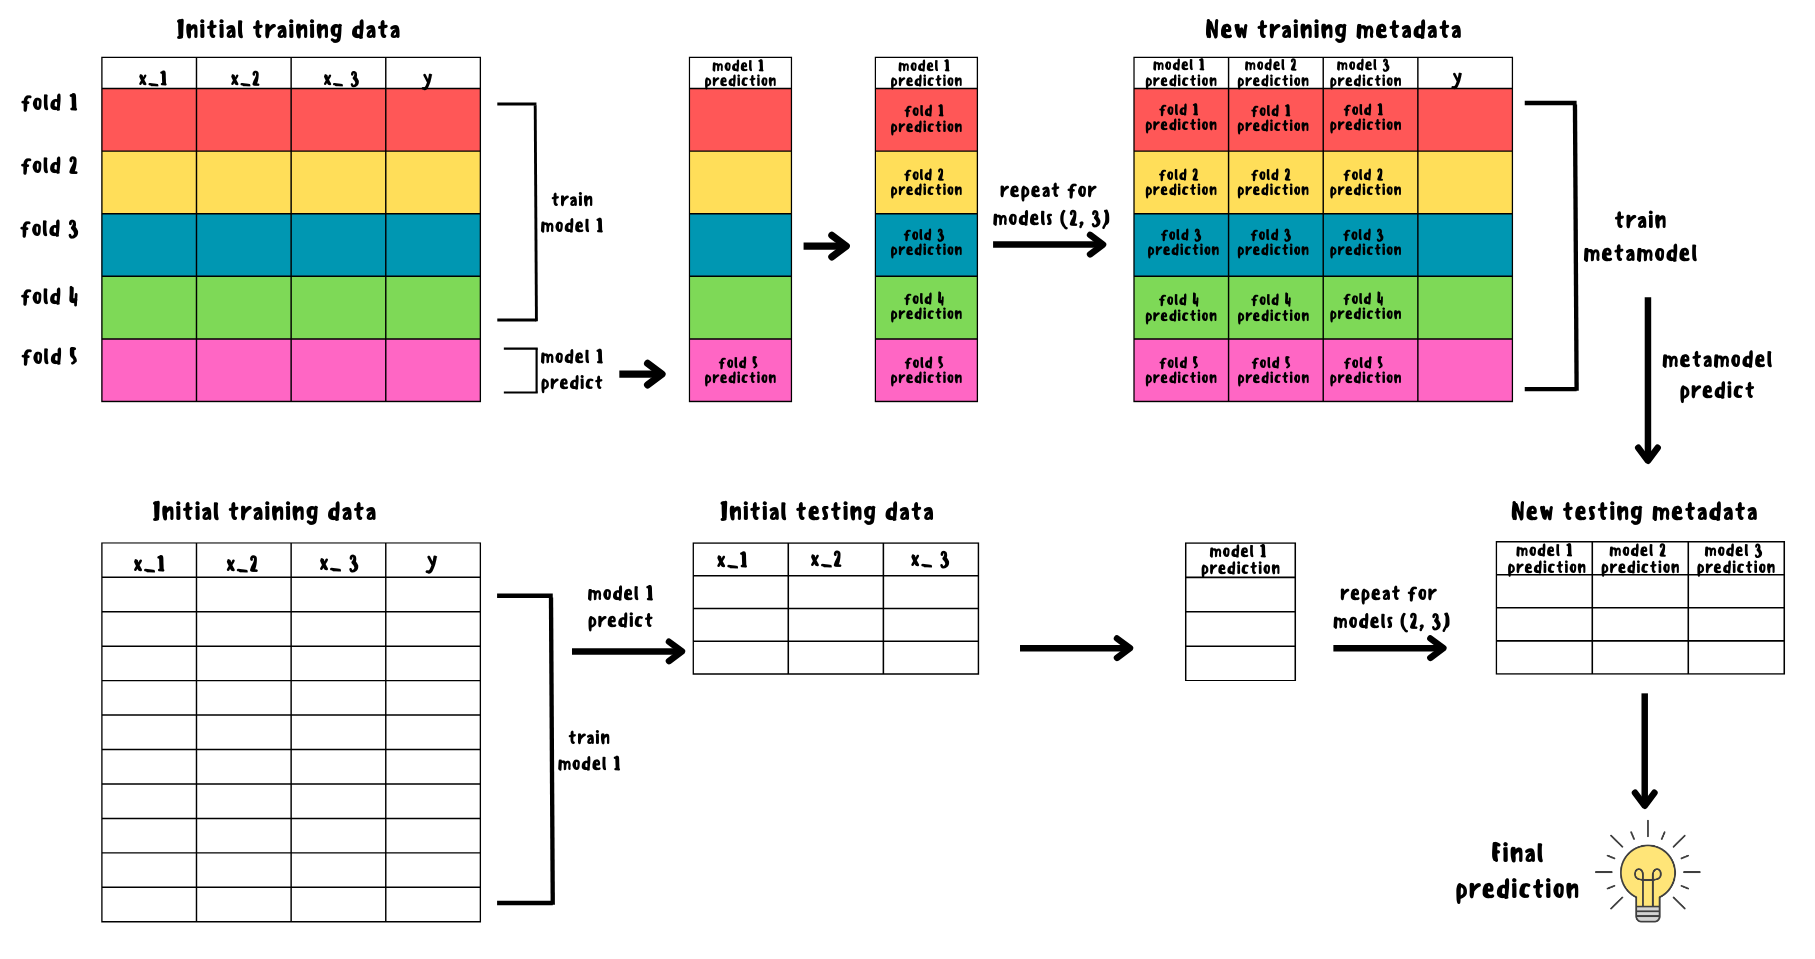

### **Blending**
Blending is a simpler version of stacking. The training data is divided into 2 parts: also for training and validation using hold-out cross-validation. The basic model is trained on the training data and makes a prediction on both validation and test set. Next, the previous step is repeated for each base model: the target *y_val* is added to the predictions on the validation set and the resulting dataset is used as a training one and the predictions on the test set are used as a new test one.

A meta-model is trained on the received datasets (metadata) and a final prediction is made.

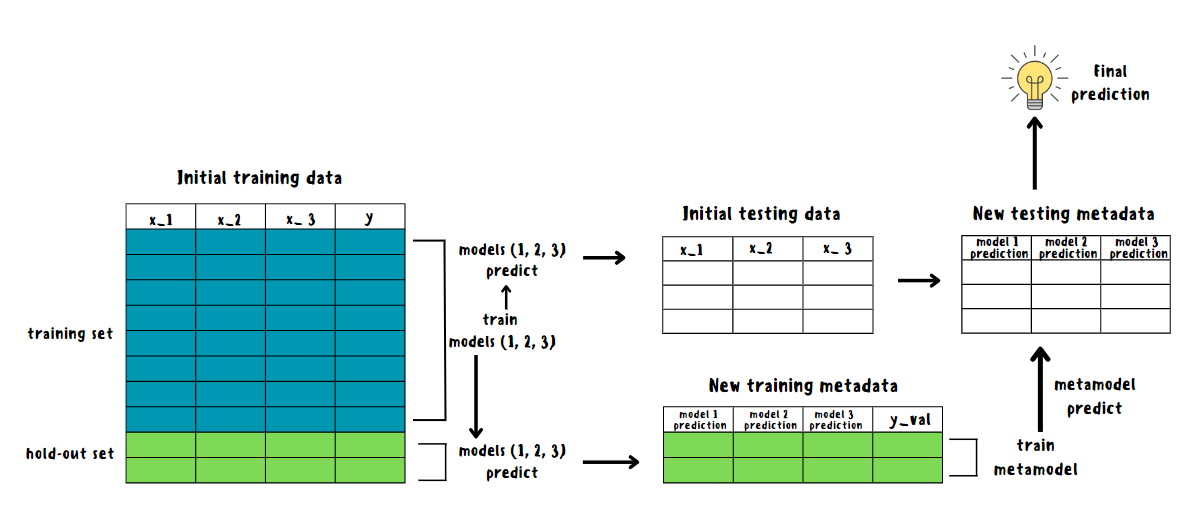

### **More advanced techniques**
To speed up the work of stacking and blending **parallelization during training** is used in practice, that is, each basic model can be trained on different cores in parallel. It's not hard to guess that this approach is especially useful when working with large datasets or complex models. In the scikit-learn implementation parallelization is implemented using the *joblib* library and the number of cores used is set using the *n_jobs* parameter (with a value of -1 all available cores are used). Parallel learning is also used in the manual implementation below.

It is also worth adding that there are other versions of stacking and blending, for example, when new metadata is added to the original. In addition, stacking and blending can be **multi-layered**, when model predictions obtained at the previous level are combined at each level and then these combined predictions are used to train new models at the next level. Sometimes this approach can give a good boost in terms of accuracy but it is worth bearing in mind that in this case the training time will also increase significantly.

At the moment, scikit-learn implements support directly only for stacking, however, if you select 1 fold for cross-validation and train the basic models separately you can remotely get something similar to blending.

### **Python implementation from scratch**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from joblib import Parallel, delayed
from mlxtend.plotting import plot_decision_regions

In [10]:
class Stacking:
    def __init__(self, estimators, final_estimator, blending=False, cv=5, n_jobs=-1):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.blending = blending
        self.cv = cv
        self.n_jobs = n_jobs

    def _X_pred(self, estimator, data):
        if self.blending:
            X_train_v, y_train_v, X_val = data
            return estimator.fit(X_train_v, y_train_v).predict(X_val)
        else:
            X_train, y_train = data
            return cross_val_predict(estimator, X_train, y_train, cv=self.cv)

    def _X_test_pred(self, estimator, data):
        X_train, y_train, X_test = data

        return estimator.fit(X_train, y_train).predict(X_test)

    def _meta_data(self, X_train, y_train, X_test):
        if self.blending:
            #used hold-out cross-validation
            X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=0)
            train_data = [X_train_v, y_train_v, X_val]
            test_data = [X_train_v, y_train_v, X_test]
            meta_y_train = y_val
        else:
            train_data = [X_train, y_train]
            test_data = [X_train, y_train, X_test]
            meta_y_train = y_train

        cv_X_train_preds = (delayed(self._X_pred)(est, train_data) for est in self.estimators)
        X_test_preds = (delayed(self._X_test_pred)(est, test_data) for est in self.estimators)

        meta_X_train = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(cv_X_train_preds))
        meta_X_test = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(X_test_preds))

        return meta_X_train.T, meta_y_train, meta_X_test.T

    def fit_predict(self, X_train, y_train, X_test):
        # meta learner or blender
        meta_X_train, meta_y_train, meta_X_test = self._meta_data(X_train, y_train, X_test)

        return self.final_estimator.fit(meta_X_train, meta_y_train).predict(meta_X_test)

In [11]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Uploading datasets**
[Glass Classification](https://www.kaggle.com/datasets/uciml/glass) dataset will be used to train models where it is necessary to correctly determine the type of glass by its characteristics. In the case of regression Diabetes dataset from scikit-learn is used.

In [12]:
df_path = "/content/drive/MyDrive/glass.csv"
glass_df = pd.read_csv(df_path)
X1, y1 = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
print(glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [13]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Model training and evaluation of the results obtained**
Both in the case of classification and regression, stacking and blending showed the same and not the best results. As a rule, this situation occurs for two reasons: given that metadata is based on predictions of basic models, the presence of weak basic models can reduce the accuracy of stronger ones which will reduce the final prediction as a whole. Also a small amount of training data often leads to overfitting which in turn reduces the accuracy of predictions.

In this case the problem can be partially solved by setting stack_method='predict_proba' when each basic classifier outputs class membership probabilities instead of the classes themselves which can help increase accuracy in the case of non-mutually exclusive classes. Also this method works better with noise in the data. As you can see this method has significantly increased the accuracy of the model. With the right selection of models and hyperparameters the accuracy will be even higher.

Most often stacking shows slightly better results than blending due to the use of k-fold cross-validation but usually the difference is noticeable only on a large amount of data.

**StackingClassifier & BlendingClassifier**

In [14]:
estimators = [LogisticRegression(random_state=0, max_iter=10000),
              GradientBoostingClassifier(random_state=0),
              SVC(probability=True, random_state=0)]

estimator = RandomForestClassifier(random_state=0)
stacking_clf = Stacking(estimators=estimators, final_estimator=estimator)
stacking_pred_res = stacking_clf.fit_predict(X1_train, y1_train, X1_test)
stacking_accuracy = accuracy_score(y1_test, stacking_pred_res)
print(f'stacking_accuracy: {stacking_accuracy}')
print(stacking_pred_res, '', sep='\n')

blending_clf = Stacking(estimators=estimators, final_estimator=estimator, blending=True)
blending_pred_res = blending_clf.fit_predict(X1_train, y1_train, X1_test)
blending_accuracy = accuracy_score(y1_test, blending_pred_res)
print(f'blending_accuracy: {blending_accuracy}')
print(blending_pred_res)

stacking_accuracy: 0.6481481481481481
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 0 0 3 0 5 5 0 0 5 0 0 1 0 0 1 0 1 0 0
 0 0 5 3 4 1 0 1 1 0 1 0 1 0 4 5 0]

blending_accuracy: 0.6481481481481481
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 0 1 5 1 5 5 1 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 3 5 1 0 1 1 0 1 0 1 0 4 5 0]


**StackingClassifier (scikit-learn)**

sk_stacking_accuracy with a predict method: 0.6481481481481481
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 0 0 3 0 5 5 0 0 5 0 0 1 0 0 1 0 1 0 0
 0 0 5 3 4 1 0 1 1 0 1 0 1 0 4 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


sk_stacking_accuracy with a predict_proba method: 0.7592592592592593
[5 0 1 4 3 1 0 1 1 1 1 0 1 1 1 5 0 1 2 2 3 0 5 5 1 0 5 0 1 1 0 0 1 0 1 0 0
 2 0 5 5 4 1 0 1 1 0 1 0 1 0 4 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


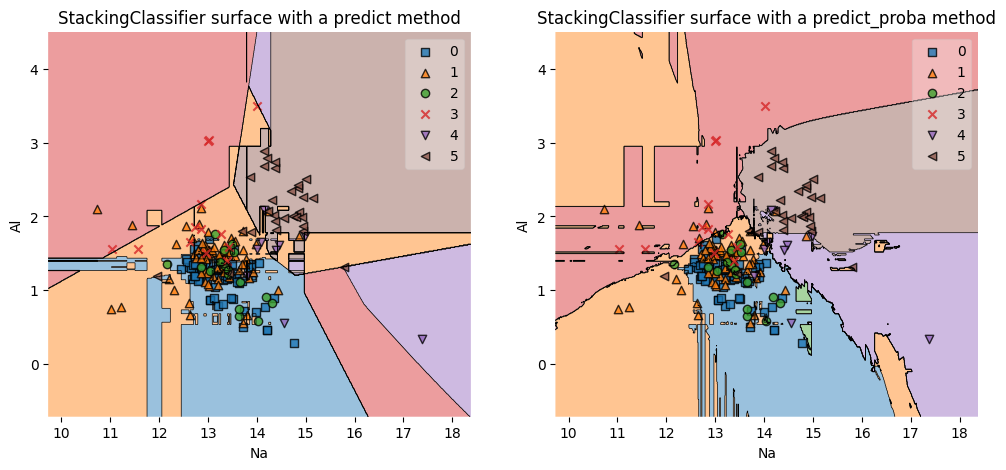

In [15]:
sk_estimators = [('lr', LogisticRegression(random_state=0, max_iter=10000)),
                 ('gbc', GradientBoostingClassifier(random_state=0)),
                 ('svc', SVC(probability=True, random_state=0))]

stack_methods = ('predict', 'predict_proba')
estimator = RandomForestClassifier(random_state=0)
sk_stacking_clf = StackingClassifier(estimators=sk_estimators, final_estimator=estimator)

feature_indexes = [1, 3]
plt.figure(figsize=(12, 5))

for i, method in enumerate(stack_methods):
    sk_stacking_clf.stack_method = method
    sk_stacking_clf.fit(X1_train, y1_train)
    sk_stacking_pred_res = sk_stacking_clf.predict(X1_test)
    sk_stacking_accuracy = accuracy_score(y1_test, sk_stacking_pred_res)
    print(f'sk_stacking_accuracy with a {method} method: {sk_stacking_accuracy}')
    print(sk_stacking_pred_res)

    plt.subplot(1, 2, i + 1)
    plt.subplots_adjust(hspace=1.5)
    title = f'StackingClassifier surface with a {method} method'
    decision_boundary_plot(X1, y1, X1_train, y1_train, sk_stacking_clf, feature_indexes, title)

**StackingRegressor & StackingRegressor (scikit-learn)**

In [16]:
reg_estimators = [RandomForestRegressor(random_state=0),
                  GradientBoostingRegressor(random_state=0)]

stacking_reg = Stacking(estimators=reg_estimators, final_estimator=RidgeCV())
stacking_reg_pred_res = stacking_reg.fit_predict(X2_train, y2_train, X2_test)
stacking_mape = mean_absolute_percentage_error(y2_test, stacking_reg_pred_res)
print(f'stacking_regressor_mape {stacking_mape}')
print(stacking_reg_pred_res, '', sep='\n')

sk_reg_estimators = [('rfr', RandomForestRegressor(random_state=0)),
                     ('gbr', GradientBoostingRegressor(random_state=0))]

sk_stacking_reg = StackingRegressor(estimators=sk_reg_estimators)
sk_stacking_reg.fit(X2_train, y2_train)
sk_stacking_reg_pred_res = sk_stacking_reg.predict(X2_test)
sk_stacking_mape = mean_absolute_percentage_error(y2_test, sk_stacking_reg_pred_res)
print(f'sk_stacking_regressor_mape {sk_stacking_mape}')
print(sk_stacking_reg_pred_res)

stacking_regressor_mape 0.39979248717477694
[248.19759057 240.42764024 177.37191492 103.86233455 200.13250024
 250.97352765  96.82048975 220.71264013 131.5200259  236.41159677
 175.71519802 160.35569454 130.9100711   93.65232358 282.06237765
  99.93621948 161.47206754  78.65895059 108.86806694 224.46260151
 182.68564834 127.54111953 163.28785267 138.89063619 220.53939703
 189.84079506 136.98136758  78.91556812 219.66245835 159.14526636
 198.39205847  82.77579781 117.59833274 157.49622357 139.53979064
 171.05953707 152.42297469 135.62774138  94.81503188 213.49660018
 110.36059875 162.00479518 132.07261264 178.57636808 179.29614901
  73.3945309  114.601665   131.93470279 100.32309962 252.57462411
 146.00870076  61.92053404 170.56742259 157.92964414 243.28628037
 205.27588938 180.79716523 114.89480581 120.80464762 172.87785542
 243.4033502  151.64437003 130.09006375 100.99049563 249.91693845
 153.00241663  87.45729779 230.20145421 215.78130712  90.82440238
  88.24276622 143.91478174 110.8

### **Pros and cons of stacking and blending**
Pros:
- significant improvement in prediction accuracy when it's used correctly.

Cons:
- high computing costs;
- the possibility of retraining due to difficulties in the correct selection and configuration of basic models, as well as difficulty in interpretation.

### **Additional sources**
Paper «An Interpretation of Stacking and Blending Approach in Machine
Learning», Divya Khyani, Soumya Jakkula, Sanjana Gowda N C, Anusha K J, Swetha K R.

Documentation:
- [Stacking description](https://scikit-learn.org/stable/modules/ensemble.html#stacking);
- [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html);
- [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html).

Video: [one](https://www.youtube.com/watch?v=xtTyEoJ31Vg&ab_channel=UnfoldDataScience), [two](https://www.youtube.com/watch?v=TuIgtitqJho).